In [1]:
import os
import numpy as np
import pandas as pd
import fitbit
import gather_keys_oauth2 as Oauth2
import datetime as dt
from datetime import datetime,date,time,timedelta

# For now, I'm storing data as the raw json that gets
# retrieved through the API, and I'll figure out later
# in the analysis how to parse this out into time series
# data and summary/metadata
import json

In [6]:
# Need to run once at beginning of session - gets authorization credentials

with open('api_keys.json','r') as key_file:
    keys=json.loads(key_file.read())
FITBIT_CLIENT_ID,FITBIT_CLIENT_SECRET=[keys[i] 
                                       for i in ('fitbit-client-id','fitbit-client-secret')]
STRAVA_CLIENT_ID,STRAVA_CLIENT_SECRET,STRAVA_ACCESS_TOKEN=[keys[i] 
                                                           for i in ('strava-client-id','strava-client-secret','strava-access-token')]

server = Oauth2.OAuth2Server(FITBIT_CLIENT_ID, FITBIT_CLIENT_SECRET)
server.browser_authorize()
ACCESS_TOKEN = str(server.fitbit.client.session.token['access_token'])
REFRESH_TOKEN = str(server.fitbit.client.session.token['refresh_token'])

# Creates the main Fitbit API object
fitbit_client = fitbit.Fitbit(FITBIT_CLIENT_ID, FITBIT_CLIENT_SECRET, oauth2=True, access_token=ACCESS_TOKEN, refresh_token=REFRESH_TOKEN)

# Grabs run data from Strava API
import stravalib
from stravalib.client import Client

client = Client()
authorize_url = client.authorization_url(client_id=STRAVA_CLIENT_ID, redirect_uri='http://localhost:8080')
client = Client(access_token=STRAVA_ACCESS_TOKEN)
runs=list(client.get_activities(limit=100))
runs=runs[::-1]

[08/Oct/2018:14:10:44] ENGINE Listening for SIGTERM.
[08/Oct/2018:14:10:44] ENGINE Listening for SIGHUP.
[08/Oct/2018:14:10:44] ENGINE Listening for SIGUSR1.
[08/Oct/2018:14:10:44] ENGINE Bus STARTING
CherryPy Checker:
The Application mounted at '' has an empty config.

[08/Oct/2018:14:10:44] ENGINE Started monitor thread 'Autoreloader'.
[08/Oct/2018:14:10:44] ENGINE Serving on http://127.0.0.1:8080
[08/Oct/2018:14:10:44] ENGINE Bus STARTED


127.0.0.1 - - [08/Oct/2018:14:10:45] "GET /?code=8452ad1b812ea29d0b36d9a269043a467064dbb3&state=G1il9oVKLQgFpMQOgAfTbglnK1QOyZ HTTP/1.1" 200 122 "" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3396.99 Safari/537.36"


[08/Oct/2018:14:10:46] ENGINE Bus STOPPING
[08/Oct/2018:14:10:51] ENGINE HTTP Server cherrypy._cpwsgi_server.CPWSGIServer(('127.0.0.1', 8080)) shut down
[08/Oct/2018:14:10:51] ENGINE Stopped thread 'Autoreloader'.
[08/Oct/2018:14:10:51] ENGINE Bus STOPPED
[08/Oct/2018:14:10:51] ENGINE Bus EXITING
[08/Oct/2018:14:10:51] ENGINE Bus EXITED
[08/Oct/2018:14:10:51] ENGINE Waiting for child threads to terminate...
No such attribute visibility on entity <Activity id=1890544331 name='Chicago Marathon' resource_state=2>
No such attribute display_hide_heartrate_option on entity <Activity id=1890544331 name='Chicago Marathon' resource_state=2>
No such attribute visibility on entity <Activity id=1888101854 name='Pre-Marathon Shakeout Run' resource_state=2>
No such attribute display_hide_heartrate_option on entity <Activity id=1888101854 name='Pre-Marathon Shakeout Run' resource_state=2>
No such attribute visibility on entity <Activity id=1882631211 name='T2 Week 18 Tempo Run' resource_state=2>
No s

In [3]:
def get_activities_list(client,d=None):
    if d==None:
        d=date.today()
    if type(d)==str:
        d_str=d
        d=date(*map(int,d_str.split('-')))
    elif isinstance(d,type(date.today())):
        d_str=d.isoformat()
    url=''.join(['https://api.fitbit.com/1/user/-/activities/list.json?afterDate=',
                 str(d-timedelta(days=1)),
                 '&sort=asc&offset=0&limit=20'])
    test=client.client.session.request('GET',url)
    acts=[i for i in json.loads(test.content.decode('utf8'))['activities'] if i['startTime'].split('T')[0]==d_str]
    return acts

def get_hrs_for_activities(client,d=None):
    acts=get_activities_list(client,d)
    activity_heartrate_list=[]
    for act in acts:
        act_hr=client.client.session.request('GET',act['heartRateLink'])
        activity_heartrate_list.append(json.loads(act_hr.content.decode('utf8')))
    return activity_heartrate_list

def parse_hr_json(hr_data,normalize_time=False):
    # Parses the json dictionary returned by the Fitbit API
    # into two lists - a series of datetime objects for each time step
    # and its associated list of HR values
    t_0=dt.time(*map(int,hr_data[0]['time'].split(':')))
    for entry in hr_data:
        new_t=dt.time(*map(int,entry['time'].split(':')))
        #new_t=(datetime.combine(date(2018,7,7), t) - timedelta(hours=0,minutes=0,seconds=0)).time()
        entry['time']=new_t
    hr_data = sorted(hr_data, key=lambda k: k['time']) 
    hr_times=[i['time'] for i in hr_data]
    hr_vals=[i['value'] for i in hr_data]
    return {'times':hr_times,'values':hr_vals}

In [4]:
def get_fitbit_activity_for_run(run):
    if isinstance(run,type(stravalib.model.Activity()))==False:
        print('Run parameter must be of type',str(type(stravalib.model.Activity())))
        return None
    strava_dt=run.start_date_local
    day=strava_dt.date()
    t=strava_dt.time()
    # Try to open activity file for the day - activity data is incomplete as of now
    try:
        fitbit_acts=json.load(open('data/activities/{:}_acts.json'.format(day.isoformat()),'r'))
        min_diff=86400
        selected_activity=None
        for act in fitbit_acts:
            start_time=act['activities-heart-intraday']['dataset'][0]['time']
            fitbit_time=time(*map(int,map(float,start_time.split(':'))))
            time_diff=abs((strava_dt-datetime.combine(day,fitbit_time)).total_seconds())
            if time_diff<min_diff:
                selected_activity=act
                min_diff=time_diff
        return selected_activity
    except FileNotFoundError:
        print('No activity data for date',day.strftime("%Y-%m-%d"))

In [8]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except (ValueError, msg):
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

/Users/codydirks/anaconda3/envs/fitness/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/codydirks/anaconda3/envs/fitness/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


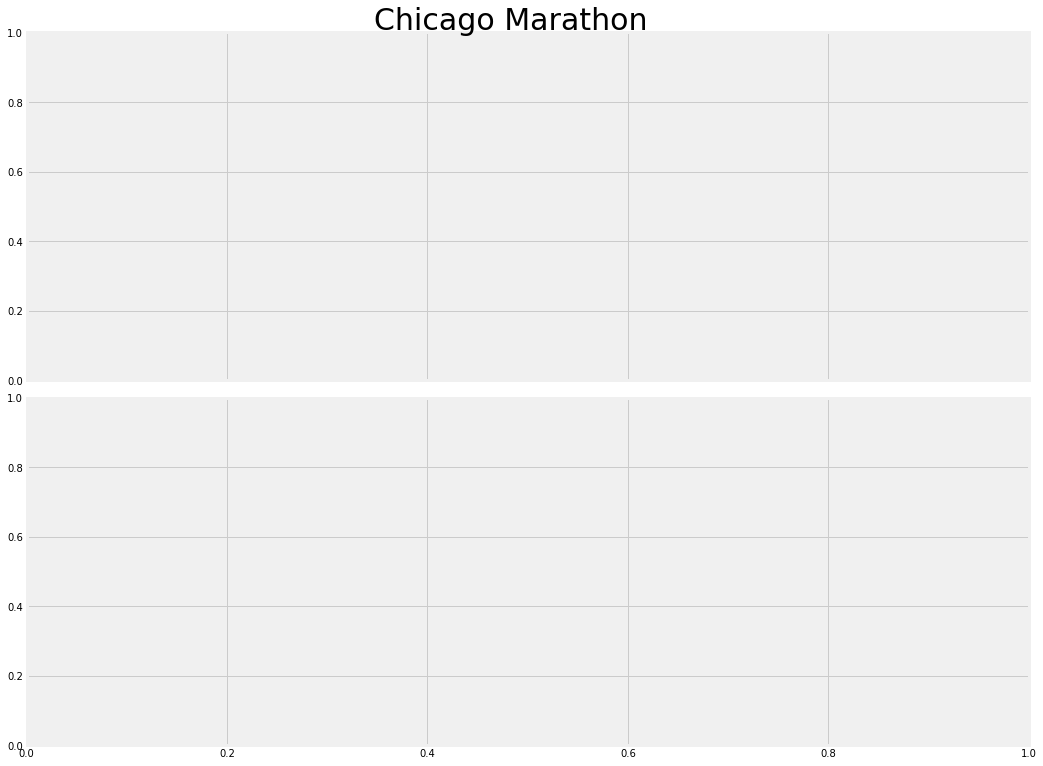

In [9]:
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sb
blue=sb.xkcd_palette(['windows blue'])[0]
red=sb.xkcd_palette(['pale red'])[0]
plt.style.use('fivethirtyeight')
% matplotlib inline

fig,(subplt1,subplt2)=plt.subplots(nrows=2,ncols=1,sharex=True,figsize=(16,12),facecolor='w')
plt.subplots_adjust(hspace=0.05,top=0.95)

for run in [i for i in runs if i.manual == False]:
    name=run.name
    #Obtain the data for a given run from Strava API and my personal HR logs
    r=client.get_activity_streams(run.id,types=['time','distance','latlng','velocity_smooth'])
    fitbit_act=get_fitbit_activity_for_run(run)
    
    f_times=[]
    f_hrs=[]
    # Rescale the fitbit time data to # of seconds since activity start, rather than actual time
    start_time=datetime.strptime(fitbit_act['activities-heart-intraday']['dataset'][0]['time'],'%H:%M:%S')
    for entry in fitbit_act['activities-heart-intraday']['dataset']:
        f_times.append((datetime.strptime(entry['time'],'%H:%M:%S')-start_time).total_seconds())
        f_hrs.append(entry['value'])
    f_times=np.array(f_times)
    f_hrs=np.array(f_hrs)
    
    
    if r != None:
        s_times,s_distances,s_vels=[np.array(r[param].data) for param in ('time','distance','velocity_smooth')]
        new_time_grid=np.linspace(0,min(f_times[-1],s_times[-1]),1000)
    else:
        new_time_grid=np.linspace(0,f_times[-1],1000)

    # Interpolate both datasets onto a uniform grid of points
    new_hrs=interp1d(f_times,f_hrs)(new_time_grid)
    new_distances=interp1d(s_times,s_distances)(new_time_grid)
    new_vels=interp1d(s_times,s_vels)(new_time_grid)*2.23694 #conversion from m/s to mph

    smoothed_hrs=savitzky_golay(new_hrs,31,10)

    xmax=int(new_distances[-1]/1609)+1
    max_hr=193
    peak=int(0.85*max_hr)
    cardio=int(0.7*max_hr)
    fat_burn=int(0.5*max_hr)
    subplt1.fill_between([0,xmax],peak,max_hr,color='r',alpha=0.2)
    subplt1.fill_between([0,xmax],cardio,peak,color='orange',alpha=0.2)
    subplt1.fill_between([0,xmax],fat_burn,cardio,color='yellow',alpha=0.2)
    subplt1.plot(new_distances/1609,smoothed_hrs,linestyle='-',color='k')
    #subplt1.set_xlim(0,new_distances[-1]/1609)
    subplt1.set_ylim(fat_burn,max_hr)
    subplt1.set_ylabel('Heart Rate',fontsize=30)

    smoothed_vels=savitzky_golay(new_vels,31,10)
    #Plot pace in intervals of x miles
    x=1
    for i in np.arange(0,new_distances[-1]/1609,x):
        val=np.mean(smoothed_vels[np.where((new_distances/1609>i)&(new_distances/1609<i+x)&(smoothed_vels>60/10.5))])
        if i+x<new_distances[-1]/1609:
            mx=i+x
        else:
            mx=new_distances[-1]/1609
        subplt2.plot([i,mx],[60/val,60/val],linestyle='-',color='k',lw=5)

    min_pace=min(60/smoothed_vels[np.where(smoothed_vels>60/10.5)])
    min_pace=min(60/smoothed_vels[np.where(smoothed_vels>60/10.5)])
    time_ticks=np.arange(7,11,0.25)
    subplt2.set_xlabel('Mile',fontsize=30)
    #subplt2.set_xlim(0,new_distances[-1]/1609)
    subplt2.set_ylabel('Pace (Minutes/Mile)',fontsize=30)

    subplt2.set_xticks(np.arange(0,xmax,1))
    subplt2.set_yticks(time_ticks)
    subplt2.set_yticklabels([time(*(0,int(i),int(60*(i%1)))).strftime('%M:%S') for i in time_ticks])
    for label in subplt2.yaxis.get_ticklabels()[1::2]:
        label.set_visible(False)
    #subplt2.set_ylim(7.6,9.45)
    subplt2.invert_yaxis()
    fig.suptitle(run.name,fontsize=30)
    plt.savefig('output/charts/{:}.pdf'.format(run.name))
    subplt1.cla()
    subplt2.cla()

In [ ]:
r=client.get_activity_streams(runs[-1].id,types=['time','distance','latlng','velocity_smooth'])

In [ ]:
lats,lngs=zip(*r['latlng'].data)
dist=np.array(r['distance'].data)/1609
t=np.array(r['time'].data)/3600

In [10]:
# Grabs run data from Strava API
from stravalib.client import Client

In [11]:
client = Client()

In [12]:
authorize_url = client.authorization_url(client_id=STRAVA_CLIENT_ID, redirect_uri='http://localhost:8080')

In [13]:
client = Client(access_token=STRAVA_ACCESS_TOKEN)

In [14]:
runs=list(client.get_activities(limit=100))

No such attribute visibility on entity <Activity id=1890544331 name='Chicago Marathon' resource_state=2>
No such attribute display_hide_heartrate_option on entity <Activity id=1890544331 name='Chicago Marathon' resource_state=2>
No such attribute visibility on entity <Activity id=1888101854 name='Pre-Marathon Shakeout Run' resource_state=2>
No such attribute display_hide_heartrate_option on entity <Activity id=1888101854 name='Pre-Marathon Shakeout Run' resource_state=2>
No such attribute visibility on entity <Activity id=1882631211 name='T2 Week 18 Tempo Run' resource_state=2>
No such attribute display_hide_heartrate_option on entity <Activity id=1882631211 name='T2 Week 18 Tempo Run' resource_state=2>
No such attribute visibility on entity <Activity id=1878498689 name='T2 Week 18 Recovery Run' resource_state=2>
No such attribute display_hide_heartrate_option on entity <Activity id=1878498689 name='T2 Week 18 Recovery Run' resource_state=2>
No such attribute visibility on entity <Acti